In [1]:
import os.path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# initial computation of database entry counts to achieve desired sizes
key_size = 16
value_sizes = [16, 256, 4096]
db_sizes_gb = [10, 50, 250]
gb = 1000 ** 3
entry_overhead = 4 # approximate


db_specs = pd.DataFrame([dict(value_size=vs, db_size=gb*ds)
                         for vs in value_sizes for ds in db_sizes_gb])
db_specs['entry_size'] = entry_overhead + key_size + db_specs['value_size']
db_specs['entries'] = db_specs['db_size'] / db_specs['entry_size']
db_specs

,value_size,db_size,entry_size,entries
0,16,10000000000,36,2.777778e+08
1,16,50000000000,36,1.388889e+09
2,16,250000000000,36,6.944444e+09
3,256,10000000000,276,3.623188e+07
4,256,50000000000,276,1.811594e+08
5,256,250000000000,276,9.057971e+08
6,4096,10000000000,4116,2.429543e+06
7,4096,50000000000,4116,1.214772e+07
8,4096,250000000000,4116,6.073858e+07


In [3]:
single_gb_file_specs = db_specs[db_specs['db_size'] == 10*gb].set_index('value_size')['entries']
single_gb_file_specs

value_size
16      2.777778e+08
256     3.623188e+07
4096    2.429543e+06
Name: entries, dtype: float64

In [4]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

In [5]:
duration_seconds = 10

results = []
with open('../benchmarks/disk_key_value/readonly/i3.2xlarge_2020_04_16.jsonl', 'rt') as fp:
    for line in fp:
        spec, counts = json.loads(line)
        spec.update(counts)
        results.append(spec)
results = pd.DataFrame(results)

results['db_size'] = results['data_path'].map(
    lambda x: int(os.path.basename(os.path.dirname(x)).replace('db', '')))
results['index'] = results['index_path'].map(os.path.basename)

results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size', 'index_path'], axis=1)


results.sample(5)

,known_key_get_frac,read_threads,seconds,trial_index,get,found,db_size,index
264,0.9,64,10,9,137148,123346,10,index100
170,0.9,64,10,0,13838,12419,10,index1000
124,0.5,1,10,9,199972,99795,10,index10
254,0.1,16,10,9,949436,94807,10,index10
243,0.1,1,10,8,2825,288,10,index1000


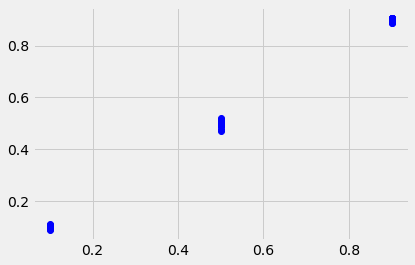

In [6]:
plt.plot(results['known_key_get_frac'], results['found'] / results['get'], 'bo')

In [7]:
x = results.copy()
x['get'] /= (duration_seconds * 1000)
agg = x.groupby(['db_size', 'index', 'known_key_get_frac', 'read_threads'])['get'].describe()
agg = agg[['count', 'min', '25%', '50%', '75%', 'max']]
agg

count      min         25%  \
db_size index     known_key_get_frac read_threads                               
10      index10   0.1                1              10.0  19.5588   19.660700   
                                     4              10.0  73.9390   74.582675   
                                     16             10.0  94.1974   94.529300   
                                     64             10.0  96.0459   98.894975   
                  0.5                1              10.0  19.6291   19.847350   
                                     4              10.0  73.7179   74.692475   
                                     16             10.0  94.8556   95.742700   
                                     64             10.0  98.1186  100.333475   
                  0.9                1              10.0  19.8023   20.175125   
                                     4              10.0  73.8380   74.826425   
                                     16             10.0  97.1253   97.476475   
                                     64             10.0  97.0300  101.269825   
        index100  0.1                1              10.0   2.6767    2.708450   
                                     4              10.0   9.9086   10.156675   
                                     16             10.0  12.6135   12.702250   
                                     64             10.0  12.7804   13.505900   
                  0.5                1              10.0   2.6938    2.712025   
                                     4              10.0  10.1232   10.145825   
                                     16             10.0  12.5864   12.667275   
                                     64             10.0  13.7131   13.741850   
                  0.9                1              10.0   2.7152    2.740050   
                                     4              10.0  10.1089   10.148675   
                                     16             10.0  12.5566   12.697275   
                                     64             10.0  12.5869   13.120025   
        index1000 0.1                1              10.0   0.2773    0.278550   
                                     4              10.0   1.0440    1.053075   
                                     16             10.0   1.2940    1.306275   
                                     64             10.0   1.4172    1.429100   
                  0.5                1              10.0   0.2783    0.279550   
                                     4              10.0   1.0450    1.055725   
                                     16             10.0   1.3097    1.312800   
                                     64             10.0   1.4069    1.426500   
                  0.9                1              10.0   0.2773    0.280975   
                                     4              10.0   1.0534    1.055775   
                                     16             10.0   1.2887    1.307925   
                                     64             10.0   1.3838    1.421275   
50      index10   0.1                1               5.0  19.7427   19.792800   
                                     4               5.0  69.1544   71.766100   
                                     16              6.0  87.9243   91.400750   
                                     64              7.0  93.9946   97.780150   
                  0.5                1               7.0  19.1511   20.093100   
                                     4               8.0  66.1665   70.141025   
                                     16              5.0  91.0574   91.899900   
                                     64              7.0  91.9470   96.638400   
                  0.9                1               8.0  19.2560   19.902525   
                                     4               6.0  71.6117   72.025400   
                                     16              9.0  92.0897   92.657300   
                                     64              5.0  94.2265  100.618000   
 

In [8]:
agg['50%'].unstack()

read_threads                                1         4         16         64
db_size index     known_key_get_frac                                         
10      index10   0.1                 19.85585  74.86740  94.88355  102.13075
                  0.5                 20.05245  75.02905  96.19870  103.68735
                  0.9                 20.21350  75.64150  97.83125  104.46680
        index100  0.1                  2.73220  10.19915  12.73375   13.68860
                  0.5                  2.72060  10.16290  12.73380   13.77565
                  0.9                  2.74845  10.16505  12.72865   13.54305
        index1000 0.1                  0.28105   1.06455   1.31705    1.44710
                  0.5                  0.28135   1.05825   1.31705    1.43565
                  0.9                  0.28300   1.05955   1.31915    1.43210
50      index10   0.1                 20.04470  71.89280  91.75550   99.07650
                  0.5                 20.19800  71.43920  92.90490  100.09640
                  0.9                 19.97845  72.37575  93.41890  101.50080
        index100  0.1                  2.74445   9.51610  12.18680   13.13155
                  0.5                  2.73075   9.59965  12.17435   12.97055
                  0.9                  2.74720   9.58630  12.18475   12.92600
        index1000 0.1                  0.28270   0.99770   1.27560    1.33460
                  0.5                  0.28790   0.99140   1.26770    1.37325
                  0.9                  0.28340   0.98090   1.26840    1.36835

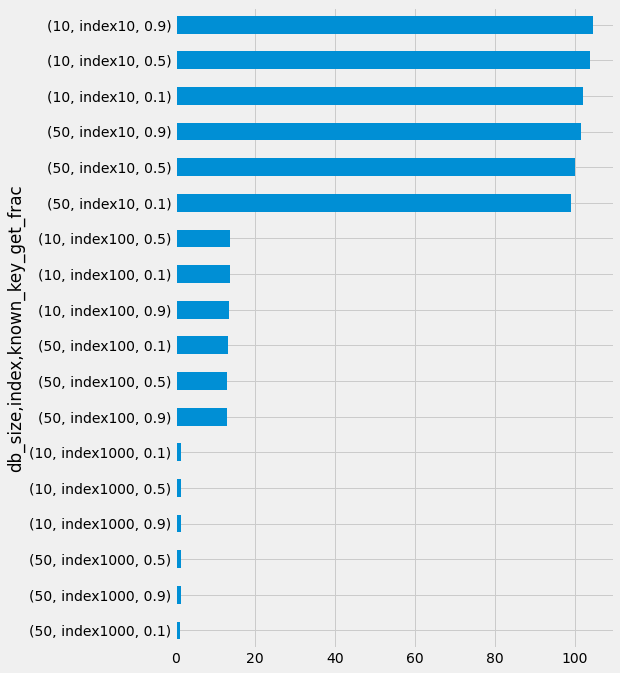

In [14]:
agg['50%'].unstack()[64].sort_values().plot.barh(figsize=(7,11))

In [19]:
((agg['75%'] - agg['25%']) / agg['50%']).describe()

count    72.000000
mean      0.016185
std       0.012127
min       0.003148
25%       0.007672
50%       0.011531
75%       0.021122
max       0.061391
dtype: float64

In [45]:
x = (agg['50%'].reset_index()
 .pivot_table('50%', ['index', 'db_size', 'read_threads'], 'known_key_get_frac'))
(x[0.9] / x[0.1]).sort_values().to_frame()

0
index     db_size read_threads          
index1000 50      4             0.983161
index100  50      64            0.984347
          10      64            0.989367
index1000 10      64            0.989634
          50      16            0.994356
          10      4             0.995303
index100  10      4             0.996657
index10   50      1             0.996695
index100  10      16            0.999599
          50      16            0.999832
                  1             1.001002
index1000 10      16            1.001594
          50      1             1.002476
index100  10      1             1.005948
index10   50      4             1.006718
index1000 10      1             1.006938
index100  50      4             1.007377
index10   10      4             1.010340
                  1             1.018012
          50      16            1.018129
          10      64            1.022873
          50      64            1.024469
index1000 50      64            1.025288
index10   10      16            1.031067

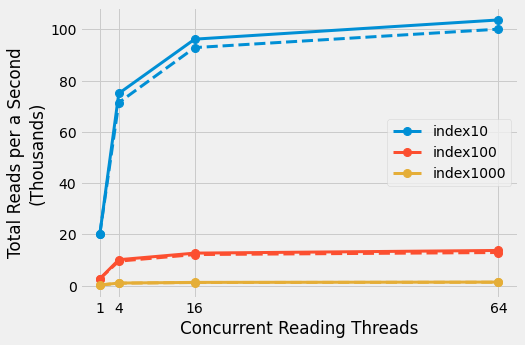

In [9]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
for (db_size, x),ls in zip(x.groupby('db_size'), ['-', '--']):
    x = x.groupby(['index', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
    x.plot(ax=ax, lw=3, ms=8, marker='o', ls=ls, color=colors[:3:])
    plt.xticks([1, 4, 16, 64])
    plt.ylabel('Total Reads per a Second\n(Thousands)')
    plt.xlabel('Concurrent Reading Threads')
for l in ax.get_lines():
    if l.get_linestyle() != '-': 
        l.set_label(None)
plt.legend()

ValueError: cannot reindex from a duplicate axis

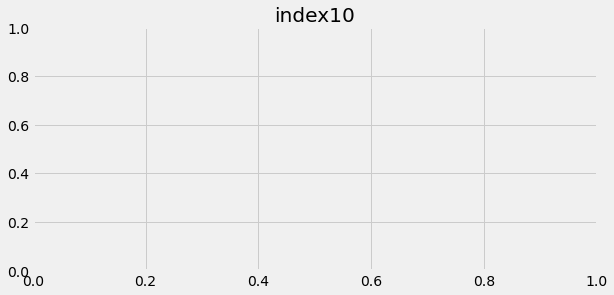

In [10]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(hspace=0.3)
for i,(index, x) in enumerate(agg.reset_index().groupby('index')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(index)
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads')
        try:
            t0 = x['50%'].loc[1]
        except KeyError:
            continue
        for c in '25%', '50%', '75%':
            x[c] /= t0
            x[c] -= 1
            x[c] *= 100
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)
        ax.set_ylim(-50, 600)
        ax.set_xticks([1, 4, 16, 64])
        ax.legend(loc='upper left')